In [1]:
from models.encdec_model import EncDecModel
from models.stacked_rnn import Stacked_RNN
from src.dataset_module import SolarEfficientDataset
from src.preprocessing import SolarPreprocessor
from utils.experiment_manager import ExperimentManager

import torch
from torchinfo import summary
import pandas as pd
from utils.early_stopping import EarlyStopping

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from codecarbon import EmissionsTracker

In [4]:
def clean_and_save(input_path, output_path):
    print(f"🧹 Iniciando limpeza do arquivo: {input_path}")
    
    # 1. Carrega os dados
    temp = pd.read_csv(input_path)
    df = temp[['Date_Time','Pot_BT','Irradiação Global horária(horizontal) kWh/m2',
               'Irradiação Difusa horária kWh/m2','Irradiação Global horária(Inclinada 27°) kWh/m2',
               'Temperatura ambiente °C','Umidade Relativa %','Velocidade média do vento m/s',
               'Pressão Baromêtrica mm Hg','Pluviômetro mm']].copy()
    
    print(f"   Linhas originais: {len(df)}")
    
    # 2. Garante que Date_Time é data real
    # Ajuste o nome da coluna se for diferente, mas pelo que vi é 'Date_Time'
    if 'Date_Time' in df.columns:
        df['Date_Time'] = pd.to_datetime(df['Date_Time'])
    else:
        print("❌ Erro: Coluna 'Date_Time' não encontrada.")
        return

    # 3. A GRANDE LIMPEZA: Remove duplicatas baseadas na DATA
    # keep='first' -> Mantém a primeira aparição e apaga as repetidas
    df_clean = df.drop_duplicates(subset=['Date_Time'], keep='first')
    
    # 4. Ordena cronologicamente (CRUCIAL para séries temporais)
    df_clean = df_clean.sort_values(by='Date_Time')
    
    # 5. Define como índice só para garantir que não tem erro, depois reseta
    df_clean = df_clean.set_index('Date_Time')
    
    # Verifica duplicatas no índice uma última vez
    if df_clean.index.duplicated().any():
        print(f"   ⚠️ Ainda encontrei duplicatas no índice. Removendo à força...")
        df_clean = df_clean[~df_clean.index.duplicated(keep='first')]
    
    # Reseta o index para salvar o CSV com a coluna Date_Time explícita
    df_clean = df_clean.reset_index()

    # 6. Salva o arquivo novo
    df_clean.to_csv(output_path, index=False)
    
    removidas = len(df) - len(df_clean)
    print(f"   ✅ Arquivo limpo salvo em: {output_path}")
    print(f"   🗑️  Linhas duplicadas removidas: {removidas}")
    print(f"   📊 Linhas finais: {len(df_clean)}")

In [5]:
if __name__ == "__main__":
    # --- CONFIGURAÇÃO ---
    # Coloque aqui o caminho do seu arquivo problemático
    ARQUIVO_SUJO = "data/pv0.csv"  
    
    # Nome do novo arquivo que vamos usar daqui pra frente
    ARQUIVO_LIMPO = "data/pv0_.csv" 
    
    clean_and_save(ARQUIVO_SUJO, ARQUIVO_LIMPO)

🧹 Iniciando limpeza do arquivo: data/pv0.csv
   Linhas originais: 66243
   ✅ Arquivo limpo salvo em: data/pv0_.csv
   🗑️  Linhas duplicadas removidas: 0
   📊 Linhas finais: 66243


⏳ Carregando dados...


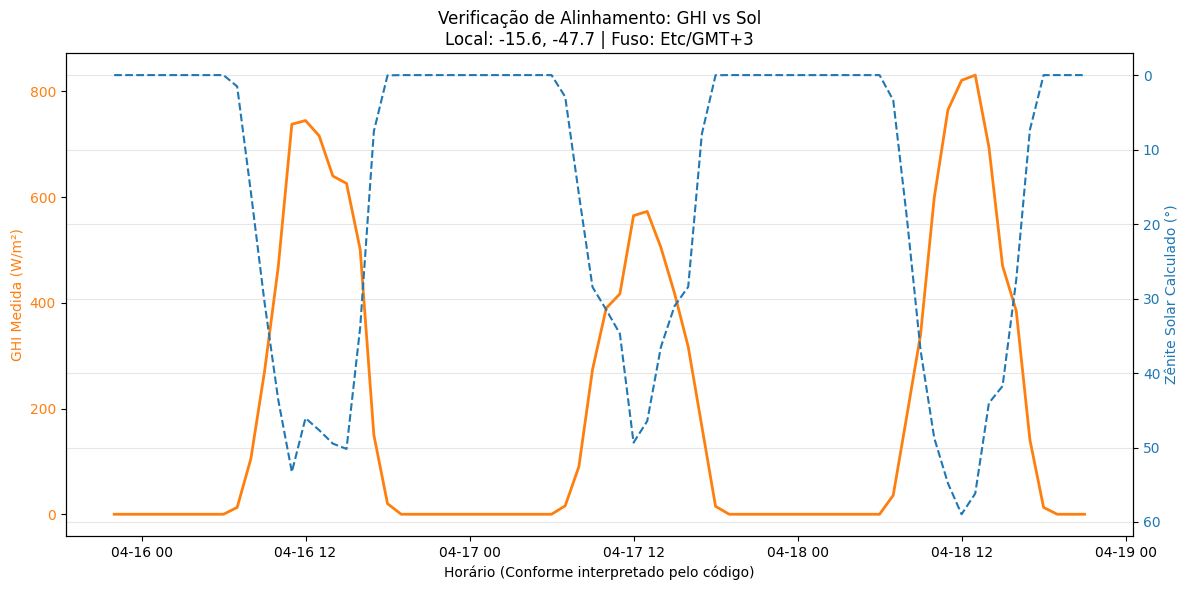

In [31]:
# 1. Configurações
CSV_PATH = 'data/pv0.csv' # Seu arquivo
LAT = -15.60
LON = -47.70
TZ = 'Etc/GMT+3' # O fuso que estamos usando

# 2. Carrega Dados (Simulando o pipeline)
print("⏳ Carregando dados...")
df = pd.read_csv(CSV_PATH)
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df = df.set_index('Date_Time').sort_index()

# Pega um recorte de 3 dias (72 horas) para visualizar
df_slice = df.iloc[60000:60072].copy()

# 3. Aplica o Preprocessamento de Posição Solar
# Vamos instanciar a classe apenas para usar as funções de geometria solar
preprocessor = SolarPreprocessor(latitude=LAT, longitude=LON, timezone=TZ)

# Força o tratamento de data igual ao do treino
df_slice = preprocessor._ensure_datetime_index(df_slice)
df_slice = preprocessor._calculate_solar_position(df_slice)

# 4. Plotagem
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo 1: Radiação Medida (GHI)
color1 = 'tab:orange'
ax1.set_xlabel('Horário (Conforme interpretado pelo código)')
ax1.set_ylabel('GHI Medida (W/m²)', color=color1)
# Tenta achar a coluna de GHI (ajuste o nome se precisar)
col_ghi = 'ghi' if 'ghi' in df_slice.columns else 'Irradiação Global horária(horizontal) kWh/m2'
if col_ghi not in df_slice.columns:
    # Tenta pegar pelo índice se não achar nome
    col_ghi = df_slice.columns[1] 

ax1.plot(df_slice.index, df_slice[col_ghi], color=color1, label='GHI Medida', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)

# Eixo 2: Zênite Solar (Calculado) - Invertido pois menor Zênite = Sol mais alto
ax2 = ax1.twinx()  
color2 = 'tab:blue'
ax2.set_ylabel('Zênite Solar Calculado (°)', color=color2)
ax2.plot(df_slice.index, df_slice['Pot_BT'], color=color2, linestyle='--', label='Posição Solar (Zênite)')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.invert_yaxis() # Inverte para o pico do gráfico ser o meio-dia

plt.title(f'Verificação de Alinhamento: GHI vs Sol\nLocal: {LAT}, {LON} | Fuso: {TZ}')
fig.tight_layout()
plt.grid(True, alpha=0.3)

⏳ Carregando data/pv0_agressive_clean.csv...

🔍 Analisando correlação GHI vs Potência:
   Lag -5h: Correlação = -0.4646 
   Lag -4h: Correlação = -0.3156 
   Lag -3h: Correlação = -0.0492 
   Lag -2h: Correlação = 0.2716 ██
   Lag -1h: Correlação = 0.5673 █████
   Lag +0h: Correlação = 0.7614 ███████
   Lag +1h: Correlação = 0.7194 ███████
   Lag +2h: Correlação = 0.4657 ████
   Lag +3h: Correlação = 0.1395 █
   Lag +4h: Correlação = -0.1757 
   Lag +5h: Correlação = -0.4023 

🎯 DIAGNÓSTICO: A Potência parece estar deslocada em +0 horas.
   ✅ Os dados parecem estar alinhados.

📸 Gráfico salvo em 'diagnostico_potencia.png'


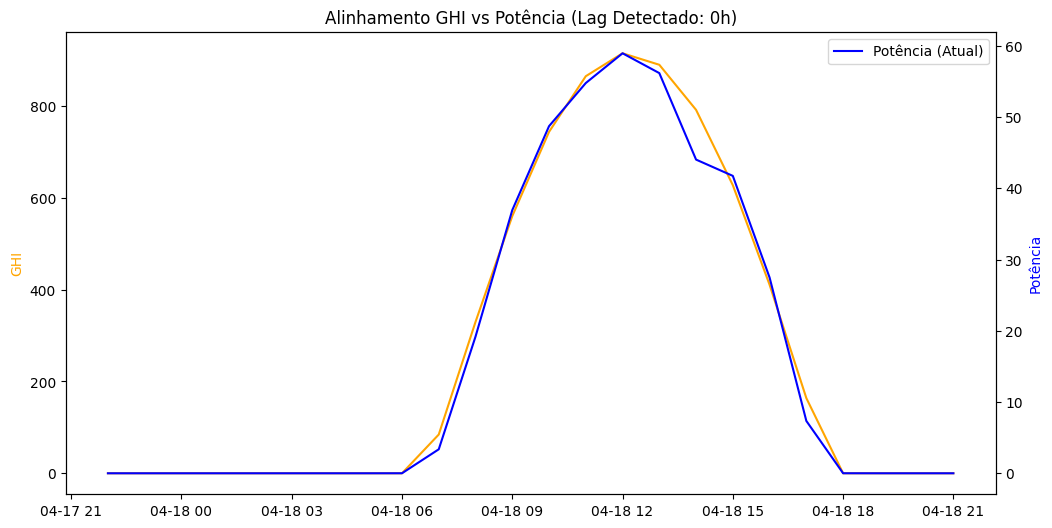

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def analisar_atraso():
    # 1. Carrega o arquivo (use o mais limpo que tiver)
    CSV_PATH = 'data/pv0_agressive_clean.csv' 
    
    print(f"⏳ Carregando {CSV_PATH}...")
    try:
        df = pd.read_csv(CSV_PATH)
    except FileNotFoundError:
        df = pd.read_csv('data/pv0.csv') # Fallback
        
    df['Date_Time'] = pd.to_datetime(df['Date_Time'])
    df = df.set_index('Date_Time').sort_index()
    
    # 2. Seleciona colunas (ajuste se os nomes mudaram)
    col_ghi = 'ghi' if 'ghi' in df.columns else 'Irradiação Global horária(horizontal) kWh/m2'
    col_pot = 'target' if 'target' in df.columns else 'Pot_BT'
    
    # Remove a noite (ruído) para melhorar a correlação
    df_day = df[(df[col_ghi] > 10) & (df[col_pot] > 0)].copy()
    
    if len(df_day) == 0:
        print("❌ Erro: Não encontrei dados diurnos (GHI > 10 e Pot > 0). Verifique os nomes das colunas.")
        print(f"Colunas disponíveis: {df.columns.tolist()}")
        return

    # 3. Normaliza para comparar (Escala 0 a 1)
    ghi_norm = (df_day[col_ghi] - df_day[col_ghi].min()) / (df_day[col_ghi].max() - df_day[col_ghi].min())
    pot_norm = (df_day[col_pot] - df_day[col_pot].min()) / (df_day[col_pot].max() - df_day[col_pot].min())

    # 4. Calcula Correlação Cruzada (Cross-Correlation)
    # Testa deslocamentos de -5 a +5 horas
    lags = range(-5, 6) 
    correlations = []
    
    print("\n🔍 Analisando correlação GHI vs Potência:")
    for lag in lags:
        # Shift na potência para ver se encaixa na GHI
        shifted_pot = pot_norm.shift(lag)
        corr = ghi_norm.corr(shifted_pot)
        correlations.append(corr)
        barra = "█" * int(corr * 10) if pd.notna(corr) else ""
        print(f"   Lag {lag:+d}h: Correlação = {corr:.4f} {barra}")
    
    best_lag = lags[np.argmax(correlations)]
    print(f"\n🎯 DIAGNÓSTICO: A Potência parece estar deslocada em {best_lag:+d} horas.")
    
    if best_lag == 0:
        print("   ✅ Os dados parecem estar alinhados.")
    elif best_lag < 0:
        print(f"   ⚠️ A Potência acontece {abs(best_lag)}h ANTES da GHI (Estranho).")
        print(f"   🔧 Correção sugerida: df['{col_pot}'] = df['{col_pot}'].shift({-best_lag})")
    else:
        print(f"   ⚠️ A Potência acontece {best_lag}h DEPOIS da GHI (Atraso).")
        print(f"   🔧 Correção sugerida: df['{col_pot}'] = df['{col_pot}'].shift({-best_lag})")

    # 5. Visualização (Zoom em 3 dias)
    # Pega um pedaço original (com noite) para plotar
    df_plot = df.iloc[60048:60072] 
    
    df_plot = preprocessor._ensure_datetime_index(df_plot)
    df_plot = preprocessor._calculate_solar_position(df_plot)

    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax1.plot(df_plot.index, df_plot['ghi_cs_theo'], color='orange', label='GHI (Sol)')
    ax1.set_ylabel('GHI', color='orange')
    
    ax2 = ax1.twinx()
    ax2.plot(df_plot.index, df_plot[col_pot], color='blue', label='Potência (Atual)')
    
    # Plota a correção sugerida (pontilhada)
    if best_lag != 0:
        corrected = df_plot[col_pot].shift(-best_lag)
        ax2.plot(df_plot.index, corrected, color='green', linestyle='--', label=f'Potência Corrigida (Shift {-best_lag}h)')
    
    ax2.set_ylabel('Potência', color='blue')
    plt.title(f'Alinhamento GHI vs Potência (Lag Detectado: {best_lag}h)')
    plt.legend()
    #plt.savefig('diagnostico_potencia.png')
    print("\n📸 Gráfico salvo em 'diagnostico_potencia.png'")

if __name__ == "__main__":
    analisar_atraso()

In [34]:
df_slice

,Pot_BT,Irradiação Global horária(horizontal) kWh/m2,Irradiação Difusa horária kWh/m2,Irradiação Global horária(Inclinada 27°) kWh/m2,Temperatura ambiente °C,Umidade Relativa %,Velocidade média do vento m/s,Pressão Baromêtrica mm Hg,Pluviômetro mm,zenith,azimuth,extra_rad,ghi_cs_theo,dhi_cs_theo
Date_Time,,,,,,,,,,,,,,
2022-04-15 22:00:00-03:00,0.000000,0.0,0.0,0.0,14.71,81.0,0.691,765.0,0.0,147.694643,264.121865,1356.065650,0.000000,0.00000
2022-04-15 23:00:00-03:00,0.000000,0.0,0.0,0.0,13.97,84.0,0.135,766.0,0.0,161.910626,254.325778,1356.065650,0.000000,0.00000
2022-04-16 00:00:00-03:00,0.000000,0.0,0.0,0.0,14.15,82.6,0.193,765.0,0.0,173.899098,205.605263,1356.065650,0.000000,0.00000
2022-04-16 01:00:00-03:00,0.000000,0.0,0.0,0.0,14.72,80.1,0.094,765.0,0.0,166.787358,113.125601,1356.065650,0.000000,0.00000
2022-04-16 02:00:00-03:00,0.000000,0.0,0.0,0.0,14.58,87.6,0.177,765.0,0.0,152.820355,98.315961,1356.065650,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-18 17:00:00-03:00,7.347750,141.0,79.0,180.0,20.14,71.9,0.980,766.0,0.0,76.522796,285.739713,1354.519259,163.684796,49.47133
2022-04-18 18:00:00-03:00,0.004267,13.0,11.0,13.0,19.05,78.9,0.625,766.0,0.0,90.577254,281.313587,1354.519259,0.000000,0.00000
2022-04-18 19:00:00-03:00,0.000000,0.0,0.0,0.0,18.55,80.1,0.622,766.0,0.0,104.833328,277.594557,1354.519259,0.000000,0.00000
